In [1]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


# I - Fonctions

In [2]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import OneHotEncoder
import  matplotlib.pyplot as plt
import pickle

def nettoyage_donnees_AIS(emplacement_file):
    """
    prend en entrée le tableur avec les donnees AIS,
    retourne un dataframe avec les valeurs qui nous interesse vraiment
    """
    #Recuperation des donnees
    data = pd.read_csv(emplacement_file)

    #On garde seulement les donnees importantes
    data = data[['BaseDateTime','LAT','LON','SOG','COG','Heading','VesselName','VesselType','Status','Length','Width','Draft','Cargo']]

    #Il manque des valeurs de "Cargo", on va les remplacer par la mediane du type de navire associé
    data['Cargo'] = data.groupby('VesselType')['Cargo'].transform(lambda x: x.fillna(x.median()))

    return data

def train_trajectory_model(data: object) -> object:
    """
    Entraine un modèle en prenant en entrée un dataframe Data
    :param data:
    :return:
    """
    data['BaseDateTime'] = pd.to_datetime(data['BaseDateTime'])
    data['delta'] = 0

    # 2. Créer les cibles à différents horizons temporels
    data = add_deltas(data)

    data['LAT_d'] = data.groupby('VesselName')['LAT'].shift(-1)
    data['LON_d'] = data.groupby('VesselName')['LON'].shift(-1)

    # Supprimer les lignes où LAT ou LON est NaN
    data = data.dropna(subset=['LAT', 'LON','LAT_d','LON_d'])

    # Variables explicatives
    X= data[['LAT','LON','SOG', 'COG', 'Heading', 'Length','Draft','Width','Cargo', 'VesselType','delta']]
    y = data[['LAT_d', 'LON_d']]

    cat_features = ['VesselType', 'Cargo']
    num_features = ['LAT', 'LON', 'SOG', 'COG','Heading','Length','Draft','Width','delta']

    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features),
        ],
        remainder='passthrough'  #Laisse passer les valeurs numériques sans les modifier
    )
    model = Pipeline([
        ('preprocess', preprocessor),
        ('model', RandomForestRegressor())
    ])

    # 5-fold CV
    scores = cross_val_score(model, X, y, cv=5, scoring='r2')
    print("R² moyenne des folds:", scores.mean())
    print("Scores individuels:", scores)

    # Division en donnees d'entrainement et de test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=False)
    # Entraîner modèle
    model.fit(X_train, y_train)

    # Prédictions
    y_pred = model.predict(X_test)

    # Reconstruction des positions finales
    LAT_pred = y_pred[:, 0]
    LON_pred = y_pred[:, 1]

    LAT_true = y_test['LAT_d'].values
    LON_true = y_test['LON_d'].values

    pred_df = pd.DataFrame({'LAT_t': LAT_true,'LON_t':LON_true, 'LON': LON_pred,'LAT': LAT_pred})

    #MSE
    mse_lat = mean_squared_error(LAT_true,LAT_pred)
    mse_lon = mean_squared_error(LON_true, LON_pred)

    print(f"mse_lat = ", mse_lat)
    print(f"mse_lon = ", mse_lon)
    # Score
    score_lat = r2_score(LAT_true, LAT_pred)
    score_lon = r2_score(LON_true, LON_pred)


    print(f"R² sur la LAT  : {score_lat:.3f}")
    print(f"R² sur la LON  : {score_lon:.3f}")

    with open('/content/drive/MyDrive/tp_IA/Projet/modele.pkl', 'wb') as f:
        pickle.dump(model, f)

    return model,pred_df


def add_deltas(data):
    data_frame = data.copy()
    data_frame['BaseDateTime'] = pd.to_datetime(data_frame['BaseDateTime'])
    data_frame = data_frame.sort_values(by=['VesselName', 'BaseDateTime'])

    data_frame['delta'] = data_frame.groupby('VesselName')['BaseDateTime'].shift(-1) - data_frame['BaseDateTime']
    data_frame['delta'] = data_frame['delta'].dt.total_seconds() / 60
    data_frame['delta'] = data_frame['delta'].dropna()

    return data_frame


def afficher_difference_pred_true(pred_df):
    """
    Affiche deux graphiques représentant la différence entre les valeurs prédites et les valeurs réelles
    :param pred_df:
    :return:
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    axes[0].scatter(pred_df['LON_pred'], pred_df['LAT_pred'],c='red', label='Position prédite', s=40, alpha=0.6, zorder=1)
    axes[0].scatter(pred_df['LON'], pred_df['LAT'],c='green', label='Position vraie', s=40, alpha=0.9, zorder=2)
    for _, row in pred_df.iterrows():
        axes[0].plot([row['LON'], row['LON_pred']], [row['LAT'], row['LAT_pred']], 'k--', linewidth=0.5, alpha=0.5)
    axes[0].set_xlabel("Longitude")
    axes[0].set_ylabel("Latitude")
    axes[0].legend()

    axes[1].scatter(pred_df['LON'], pred_df['LAT'],c='green', label='Position vraie', s=40, alpha=0.6, zorder=1)
    axes[1].scatter(pred_df['LON_pred'], pred_df['LAT_pred'],c='red', label='Position prédite', s=40, alpha=0.9, zorder=2)
    for _, row in pred_df.iterrows():
        axes[1].plot([row['LON'], row['LON_pred']], [row['LAT'], row['LAT_pred']], 'k--', linewidth=0.5, alpha=0.5)
    axes[1].set_xlabel("Longitude")
    axes[1].set_ylabel("Latitude")
    axes[1].legend()
    plt.tight_layout()
    plt.show()




def prediction_vessel(data,model,VesselName):
    """
    Effectue une prédiction pour un navire précis ou alors tout les navires
    :param data:
    :param model:
    :param VesselName:
    :return:
    """
    if VesselName != "ALL":
        data = data[data['VesselName'] == VesselName].copy()

    if data.empty:
        raise ValueError(f"Aucune donnée trouvée pour le navire : {VesselName}")

    # Conversion en datetime et tri des données
    data['BaseDateTime'] = pd.to_datetime(data['BaseDateTime'])
    data = data.sort_values(by=['VesselName', 'BaseDateTime'])

    # Calcul des deltas
    data['delta'] = 0
    data = add_deltas(data)

    # Ajout des valeurs suivantes de LAT et LON
    data['LAT_d'] = data.groupby('VesselName')['LAT'].shift(-1)
    data['LON_d'] = data.groupby('VesselName')['LON'].shift(-1)

    # Création d'une copie pour la prédiction (sans perte d'information dans l'original)
    data_pred = data.dropna(subset=['LAT', 'LON', 'LAT_d', 'LON_d']).copy()

    # Variables explicatives
    X = data_pred[['LAT', 'LON', 'SOG', 'COG', 'Heading', 'Length', 'Draft', 'Width', 'Cargo', 'VesselType', 'delta']]

    # Prédiction
    y_pred = model.predict(X)

    # Ajout des prédictions dans la copie de data
    data_pred['LAT_pred'] = y_pred[:, 0]
    data_pred['LON_pred'] = y_pred[:, 1]

    pred_df = data_pred[['LAT', 'LON', 'LAT_pred', 'LON_pred']]

    return pred_df



# II-Chargement des données

In [3]:
# 📂 Charge ton CSV (modifie si besoin)
data = pd.read_csv('/content/drive/MyDrive/tp_IA/Projet/export_IA.csv')  # ou importe depuis Google Drive

# 🔁 Entraîne le modèle
model, pred_df = train_trajectory_model(data)


R² moyenne des folds: 0.9954585796231843
Scores individuels: [0.99621747 0.9947416  0.99330378 0.99681702 0.99621303]
mse_lat =  0.005484795173782207
mse_lon =  0.09606789037925674
R² sur la LAT  : 0.997
R² sur la LON  : 0.997


## I- Prédiction en fonction du nom d'un navire

/tmp/ipython-input-2-3504428331.py:139: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


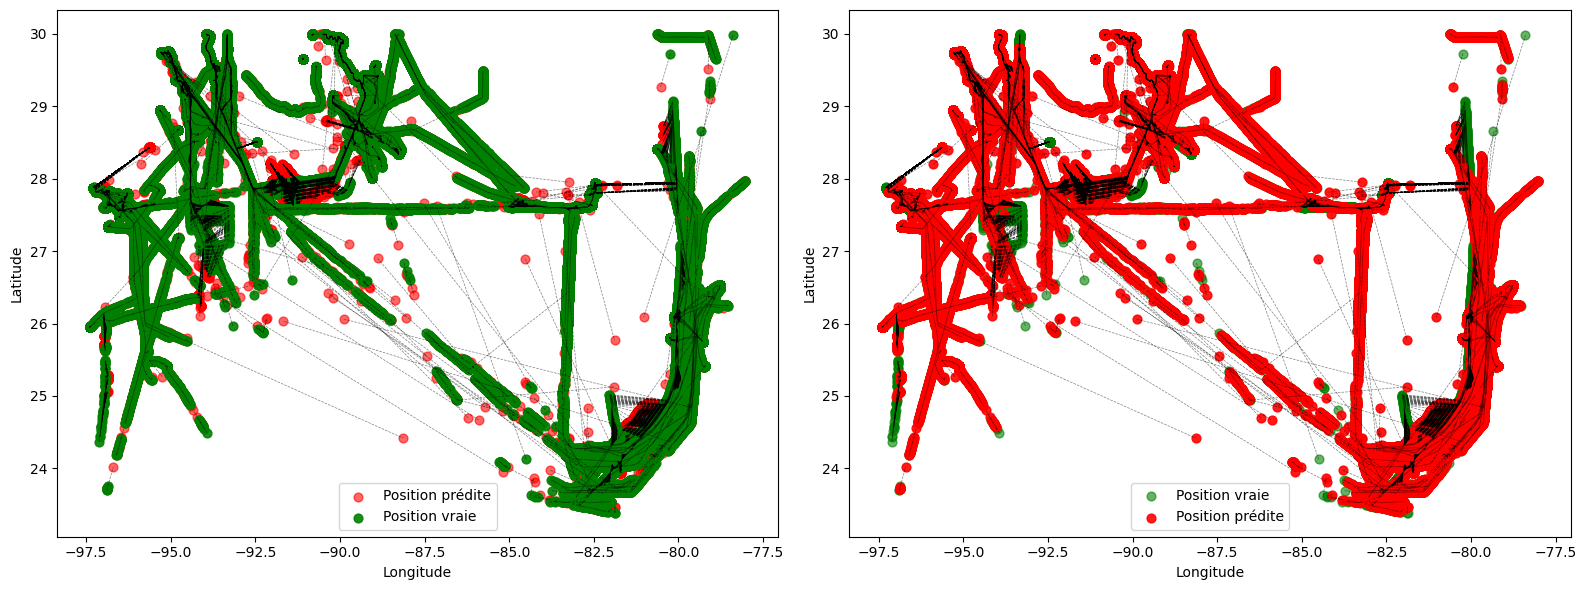

,LAT,LON,LAT_pred,LON_pred
78203,23.68752,-82.53360,23.694885,-82.557550
78234,23.68851,-82.53741,23.701563,-82.583026
78551,23.69634,-82.56708,23.758077,-82.782545
82842,23.79295,-82.90064,23.822219,-82.952508
83271,23.79945,-82.92547,23.865868,-83.032309


In [4]:
# Nom du navire à prédire
vessel_name = "ALL"

# Prédiction pour ce navire
pred_vessel_df = prediction_vessel(data, model, vessel_name)

# Affiche les résultats
afficher_difference_pred_true(pred_vessel_df)
pred_vessel_df.head()


## II- Prediction en fonction de données mises en entrée

In [ ]:
# Exemple de données manuelles
new_data = {
    'LAT': 29.72289,
    'LON': -95.23584,
    'SOG': 0.0,
    'COG': 0.0,
    'Heading': 0,
    'VesselType': 80,
    'Length': 183,
    'Width': 28,
    'Draft': 10,
    'Cargo': 83,
    'delta': 180  # minutes
}

new_df = pd.DataFrame([new_data])
pred = model.predict(new_df)
print(f"Prédiction manuelle - LAT: {pred[0,0]:.6f}, LON: {pred[0,1]:.6f}")



Prédiction manuelle - LAT: 29.722694, LON: -95.235223
